In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import os
import pyro
import copy

import numpy as np
import matplotlib.pyplot as plt

from pyro.infer.autoguide import AutoDelta, AutoLowRankMultivariateNormal, AutoGuideList

from pyciemss.PetriNetODE.interfaces import (
    load_petri_model,
    setup_model,
    sample,
    intervene,
    calibrate,
    optimize,
    prepare_interchange_dictionary,
    get_posterior_density_mesh_petri
)

from pyciemss.interfaces import DEFAULT_QUANTILES
from pyciemss.risk.ouu import computeRisk
from pyciemss.visuals import plots
from pyciemss.utils.interface_utils import csv_to_list


In [2]:
DEMO_PATH = "."
ASKENET_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/main/petrinet/examples/sir_typed.json"


## load_and_sample_petri_model

In [28]:
num_samples = 3
timepoints = [0.5, 1.0, 2.0, 3.0, 4.0]
start_time: float = -1e-10

# Run sampling w/o an intervention
model = load_petri_model(ASKENET_PATH)
model = setup_model(model, start_time=start_time)
samples = sample(model, num_samples=num_samples, timepoints=timepoints)
result = prepare_interchange_dictionary(
    samples, 
    timepoints=timepoints, 
    alpha_qs=DEFAULT_QUANTILES,
    time_unit="days",
)

# Save results
result["data"].to_csv(os.path.join(DEMO_PATH, "results_petri/sample_results.csv"), index=False)
result["quantiles"].to_csv(
    os.path.join(DEMO_PATH, "results_petri/quantiles_results.csv"), index=False
)

In [29]:
result["data"]

,timepoint_id,sample_id,beta_param,gamma_param,I_sol,R_sol,S_sol,timepoint_days
0,0,0,0.027556,0.149186,0.940984,0.072370,999.986633,0.5
1,1,0,0.027556,0.149186,0.885451,0.140468,999.974670,1.0
2,2,0,0.027556,0.149186,0.784023,0.264846,999.950989,2.0
3,3,0,0.027556,0.149186,0.694213,0.374976,999.930664,3.0
4,4,0,0.027556,0.149186,0.614691,0.472491,999.913025,4.0
5,0,1,0.027964,0.157021,0.937496,0.076030,999.986084,0.5
6,1,1,0.027964,0.157021,0.878900,0.147309,999.973083,1.0
7,2,1,0.027964,0.157021,0.772465,0.276778,999.951477,2.0
8,3,1,0.027964,0.157021,0.678917,0.390568,999.930542,3.0
9,4,1,0.027964,0.157021,0.596699,0.490578,999.913391,4.0


In [30]:
result["quantiles"]

,timepoint_id,number_days,inc_cum,output,type,quantile,value,Forecast_Backcast
0,0,0.5,inc,I,quantile,0.010,0.937566,Forecast
1,0,0.5,inc,I,quantile,0.025,0.937670,Forecast
2,0,0.5,inc,I,quantile,0.050,0.937845,Forecast
3,0,0.5,inc,I,quantile,0.100,0.938194,Forecast
4,0,0.5,inc,I,quantile,0.150,0.938542,Forecast
...,...,...,...,...,...,...,...,...
340,4,4.0,inc,S,quantile,0.850,999.913281,Forecast
341,4,4.0,inc,S,quantile,0.900,999.913318,Forecast
342,4,4.0,inc,S,quantile,0.950,999.913354,Forecast
343,4,4.0,inc,S,quantile,0.975,999.913373,Forecast


In [31]:
import pyciemss.risk.qoi
from pyciemss.risk.risk_measures import alpha_superquantile

def qoi_fn(y):
    return getattr(pyciemss.risk.qoi, qoi[0])(y, [qoi[1]], *qoi[2:])

risk_results = {}
for k, vals in samples.items():
    if "_sol" in k:
        qoi = ("scenario2dec_nday_average", k, 2)
        qois_sq = qoi_fn(samples)
        sq_est = alpha_superquantile(qois_sq, alpha=0.95)
        risk_results.update({k: {"risk": [sq_est], "qoi": qois_sq}})

risk_results

{'I_sol': {'risk': [0.7521411180496216],
  'qoi': array([0.6544518, 0.6378083, 0.7521411], dtype=float32)},
 'R_sol': {'risk': [0.4405732750892639],
  'qoi': array([0.4237337 , 0.44057328, 0.33096963], dtype=float32)},
 'S_sol': {'risk': [999.9219970703125],
  'qoi': array([999.9219, 999.922 , 999.9164], dtype=float32)}}

## load_and_sample_petri_modelwith interventions

In [32]:
interventions = [(1.1, "beta", 1.0), (2.1, "gamma", 0.1), (1.3, "beta", 2.0), (1.4, "gamma", 0.3)]

model = load_petri_model(ASKENET_PATH)
model = setup_model(model, start_time=start_time)
model = intervene(model, interventions)
samples = sample(model, num_samples=num_samples, timepoints=timepoints)
result_int = prepare_interchange_dictionary(
    samples, 
    timepoints=timepoints, 
    alpha_qs=DEFAULT_QUANTILES,
    time_unit="days",
    visual_options={"title": "SIR Model", "keep": ".*_sol"}
)

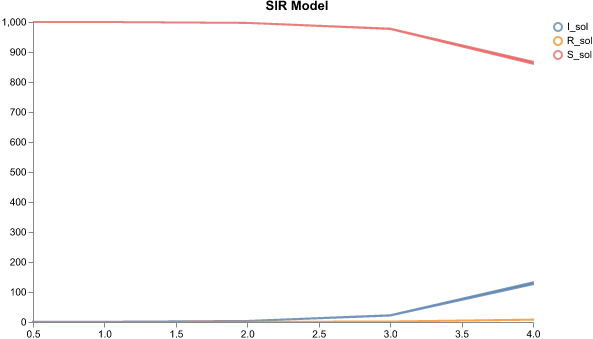

In [33]:
# Save results
result_int["data"].to_csv(
    os.path.join(DEMO_PATH, "results_petri/sample_results_w_interventions.csv"),
    index=False,
)
result_int["quantiles"].to_csv(
    os.path.join(DEMO_PATH, "results_petri/quantiles_results_w_interventions.csv"), index=False
)

plots.ipy_display(result_int["visual"])

## load_and_calibrate_and_sample_petri_model

In [44]:
data_path = os.path.join(DEMO_PATH, "data.csv")
num_samples = 10
timepoints = [0.0, 1.0, 2.0, 3.0, 4.0]

model = load_petri_model(ASKENET_PATH)
model = setup_model(model, start_time=start_time)


def autoguide(model):
    guide = AutoGuideList(model)
    guide.append(
        AutoDelta(
            pyro.poutine.block(model, expose=[])
        )
    )
    guide.append(
        AutoLowRankMultivariateNormal(
            pyro.poutine.block(model, hide=[])
        )
    )
    return guide

data = csv_to_list(data_path)
inferred_parameters = calibrate(model, data, num_iterations=100, autoguide=autoguide)
samples = sample(model, num_samples=num_samples, timepoints=timepoints)
result_cal = prepare_interchange_dictionary(
    samples, 
    timepoints=timepoints, 
    alpha_qs=DEFAULT_QUANTILES,
    time_unit="days",
    visual_options={"title": "Intervened SIR Model", "keep":".*_sol"},
)

In [49]:
result_cal["data"].head()

,timepoint_id,sample_id,beta_param,gamma_param,I_sol,R_sol,S_sol,timepoint_days
0,0,0,0.027876,0.101696,1.000000,1.016965e-11,1000.000000,0.0
1,1,0,0.027876,0.101696,0.928812,9.803213e-02,999.973145,1.0
2,2,0,0.027876,0.101696,0.862692,1.890853e-01,999.946716,2.0
3,3,0,0.027876,0.101696,0.801276,2.736569e-01,999.925171,3.0
4,4,0,0.027876,0.101696,0.744233,3.522076e-01,999.903564,4.0


In [50]:
result_cal["quantiles"]

,timepoint_id,number_days,inc_cum,output,type,quantile,value,Forecast_Backcast
0,0,0.0,inc,I,quantile,0.010,1.000000,Forecast
1,0,0.0,inc,I,quantile,0.025,1.000000,Forecast
2,0,0.0,inc,I,quantile,0.050,1.000000,Forecast
3,0,0.0,inc,I,quantile,0.100,1.000000,Forecast
4,0,0.0,inc,I,quantile,0.150,1.000000,Forecast
...,...,...,...,...,...,...,...,...
340,4,4.0,inc,S,quantile,0.850,999.915628,Forecast
341,4,4.0,inc,S,quantile,0.900,999.916248,Forecast
342,4,4.0,inc,S,quantile,0.950,999.917017,Forecast
343,4,4.0,inc,S,quantile,0.975,999.917401,Forecast


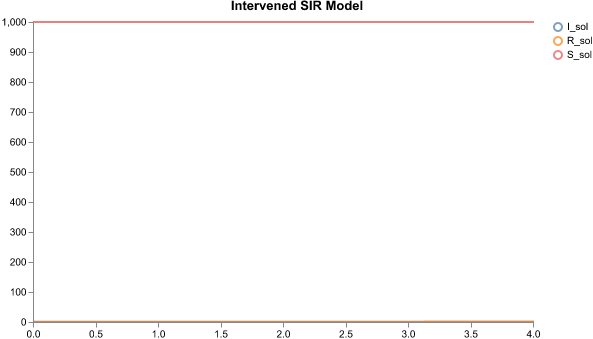

In [51]:
plots.ipy_display(result_cal["visual"])

Text(0, 0.5, 'gamma')

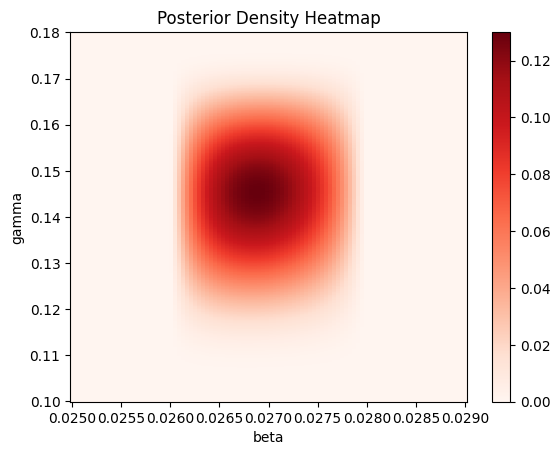

In [53]:
params, density = get_posterior_density_mesh_petri(inferred_parameters=inferred_parameters, 
                                                   mesh_params={"beta": (0.025, 0.029, 100), 
                                                                "gamma": (0.1, 0.18, 500)})

fig, ax = plt.subplots()
c = ax.pcolormesh(params["beta"], params["gamma"], density, cmap='Reds')
ax.set_title('Posterior Density Heatmap')
fig.colorbar(c, ax=ax)
ax.set_xlabel('beta')
ax.set_ylabel('gamma')

## load_and_optimize_and_sample_petri_model
Note that this only uses n_samples_ouu=2 for demonstration purposes. The number of samples to ensure acceptable Monte Carlo error should be set to higher values.

In [73]:
num_samples = 100
timepoints = [0.0, 1.0, 2.0, 3.0, 4.0]
OBJFUN = lambda x: np.abs(x)
INTERVENTION = [(0.1, "beta")]
QOI = ("scenario2dec_nday_average", "I_sol", 2)
objfun = lambda x: np.sum(np.abs(x))
def qoi_fn(y):
    return getattr(pyciemss.risk.qoi, QOI[0])(y, [QOI[1]], *QOI[2:])

model = load_petri_model(ASKENET_PATH)
model = setup_model(model, start_time=start_time)
ouu_policy = optimize(
    model,
    timepoints=timepoints,
    interventions=INTERVENTION,
    qoi=qoi_fn,
    risk_bound=10.,
    objfun=OBJFUN,
    initial_guess=0.02,
    bounds=[[0.],[3.]],
    verbose=True,
    method="euler",
    n_samples_ouu=2,
)

RISK = computeRisk(
        model=copy.deepcopy(model),
        interventions=INTERVENTION,
        qoi=qoi_fn,
        tspan=timepoints,
        risk_measure=lambda z: alpha_superquantile(z, alpha=0.95),
        num_samples=num_samples,
    )
samples = RISK.propagate_uncertainty(ouu_policy["policy"])


Time taken: (1.02e-02 seconds per model evaluation).
Performing risk-based optimization under uncertainty (using alpha-superquantile)
Estimated wait time 1.5 seconds...


 68%|██████▊   | 51/75 [00:00<00:00, 113.04it/s]


Optimization completed in time 0.45 seconds.
Optimal policy:	0.0
Post-processing optimal policy...
Estimated risk at optimal policy [0.7688]


## load_and_calibrate_and_optimize_and_sample_petri_model

In [87]:
data_path = os.path.join(DEMO_PATH, "data.csv")
num_samples = 100
timepoints = [0.0, 1.0, 2.0, 3.0, 4.0]
OBJFUN = lambda x: np.abs(x)
INTERVENTION = [(0.1, "beta")]
QOI = ("scenario2dec_nday_average", "I_sol", 2)
def qoi_fn(y):
    return getattr(pyciemss.risk.qoi, QOI[0])(y, [QOI[1]], *QOI[2:])

model = load_petri_model(ASKENET_PATH)
model = setup_model(model, start_time=start_time)

#inferred_parameters = calibrate(model, data, num_iterations=100, autoguide=autoguide)

inferred_parameters = calibrate(
    model,
    data=data,
    autoguide=autoguide,
)

ouu_policy = optimize(
    model,
    inferred_parameters=inferred_parameters,
    timepoints=timepoints,
    interventions=INTERVENTION,
    qoi=qoi_fn,
    risk_bound=10.,
    objfun=OBJFUN,
    initial_guess=0.02,
    bounds=[[0.],[3.]],
    verbose=True,
    method="euler",
    n_samples_ouu=2,
)

x = list(np.atleast_1d(ouu_policy["policy"]))
interventions_opt = [(intervention[0], intervention[1], value)
                     for intervention, value in zip(interventions, x)]

result = prepare_interchange_dictionary(
    samples,
    timepoints,
    interventions=interventions_opt,
    time_unit="days",
    train_endpoint=max([d[0] for d in data])
)

# Save results
result["data"].to_csv(
    os.path.join(DEMO_PATH, "results_petri/calibrate_optimize_sample_results.csv"), index=False
)
print("Optimal policy after calibration:", ouu_policy["policy"])
print("Estimated risk at optimal policy after calibration", ouu_policy["risk"])

Time taken: (8.74e-03 seconds per model evaluation).
Performing risk-based optimization under uncertainty (using alpha-superquantile)
Estimated wait time 1.3 seconds...


 68%|██████▊   | 51/75 [00:00<00:00, 79.81it/s]


Optimization completed in time 0.64 seconds.
Optimal policy:	0.0
Post-processing optimal policy...
Estimated risk at optimal policy [0.7686]
Optimal policy after calibration: 0.0
Estimated risk at optimal policy after calibration [0.7686]
